In [2]:
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [24]:
class FashionMNIST(d2l.DataModule):  # download the MNIST dataset
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
            #training dataset 60000 images
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)
            #test dataset 10000 images
        # downloads the data from the torchvision library: 10 catagories

In [25]:
data = FashionMNIST(resize=(32, 32)) #grayscale and upscaled to 32x32
len(data.train), len(data.val)

(60000, 10000)

In [26]:
@d2l.add_to_class(FashionMNIST)  #replaced the indices to text labels
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val # chooses training or validation dataset based on input "train"
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)
#Dataloader wraps the dataset into mini-batches

In [27]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [28]:
tic = time.time()
for X, y in data.train_dataloader(): # just tests how long it takes to read the data
    continue
f'{time.time() - tic:.2f} sec'

'2.73 sec'

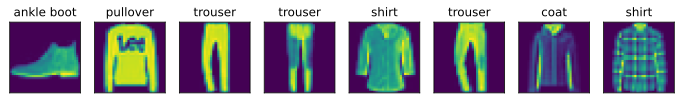

In [29]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [ ]:
class Classifier(d2l.Module):  # Model defining classification method
    """The base class of classification models."""
    def validation_step(self, batch): #defines what happens in the validation step
        Y_hat = self(*batch[:-1]) # calls the model with all but the last element of the prediction batch
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        #train=False means that the model is not being trained, just evaluated

In [38]:
@d2l.add_to_class(d2l.Module)  #adds SGD optimizer to the model
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [39]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [40]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [41]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
        # Flatten converts the input tensor to a 1D tensor
        # LazyLinear allows the model to infer the input size automatically

    def forward(self, X):
        return self.net(X)

In [42]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

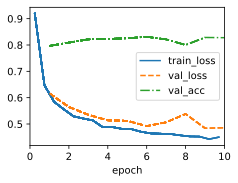

In [43]:
# Training the model
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)